# Average Precision

## Introduction

Let's assume you have a few binary classifiers which tries to distinguish some 'positive class' (called 'signal' here) from 'negative class' (called 'background' here). 

Your aim:
* choose the best classifier

* choose a 'cut' or 'threshold' on the best classifier's score to minimize misclassification rate

We briefly introduce standard graphical methods - 'receiver operating characteristic (ROC) curve' and 'precision-recall curve' and their associated metrics to compare classifiers. We dicuss which method is better, and how to choose the best threshold for a classifier for a given dataset.

In [1]:
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from ipywidgets import *

The function below is used to generate classification scores of a class as gaussian distribution.

In [2]:
def generate_scores_gaus(n, mu, sigma):
    #np.random.seed(0)
    X = np.random.normal(mu, sigma, int(n))
    return X

In [3]:
def generate_scores_gumbel(n, mu, beta):
    #np.random.seed(0)
    X = np.random.gumbel(mu, beta, int(n))
    return X

## Definitions

For a given threshold: 
<div class="alert alert-block alert-danger">
(TODO: add an interactive sliding threshold for two distributions)
</div>
    
* Precision = $\frac{TP}{TP+FP}$ = $\frac{positives\ correctly\ classified}{total\ data\ points\ classsified\ as\ positives}$

* True positive rate ($TPR$) or recall = $\frac{TP}{TP+FN}$ = $\frac{positives\ correctly\ classified}{total\ positives}$ 

* False negative rate ($FNR$) = $\frac{FN}{FN+TP}$ = $\frac{positives\ incorrectly\ classified\ as\ negatives}{total\ positives}$ = $1 - TPR$

* True negative rate ($TNR$) = $\frac{TN}{FP+TN}$ = $\frac{negatives\ correctly\ classified}{total\ negatives}$

* False positive rate ($FPR$) = $\frac{FP}{FP+TN}$ = $\frac{negatives\ incorrectly\ classified\ as\ positives}{total\ negatives}$= $1 - TNR$


In all the above metrics, except precision, the denominator is the the total strength of the true class of the numerator, so the last four metrics can be defined on the probability distribution of the score of the positive and negative classes. 
<div class="alert alert-block alert-danger">
(TODO: to explain the lines properly when the interactive sliding threshold plot is added)
</div>

## Receiver operating characteristic (ROC) curve

 ![title](https://www.medcalc.org/manual/_help/images/roc_intro1.png)

<div class="alert alert-block alert-danger">
(TODO: remake the plot above and replace it)
</div>

ROC curve can be defined as the curve between the rate of positive examples labelled as something (ie., TPR or FNR) and th rate of negative examples labelled as something (ie., TNR or FPR).


<IPython.core.display.Javascript object>


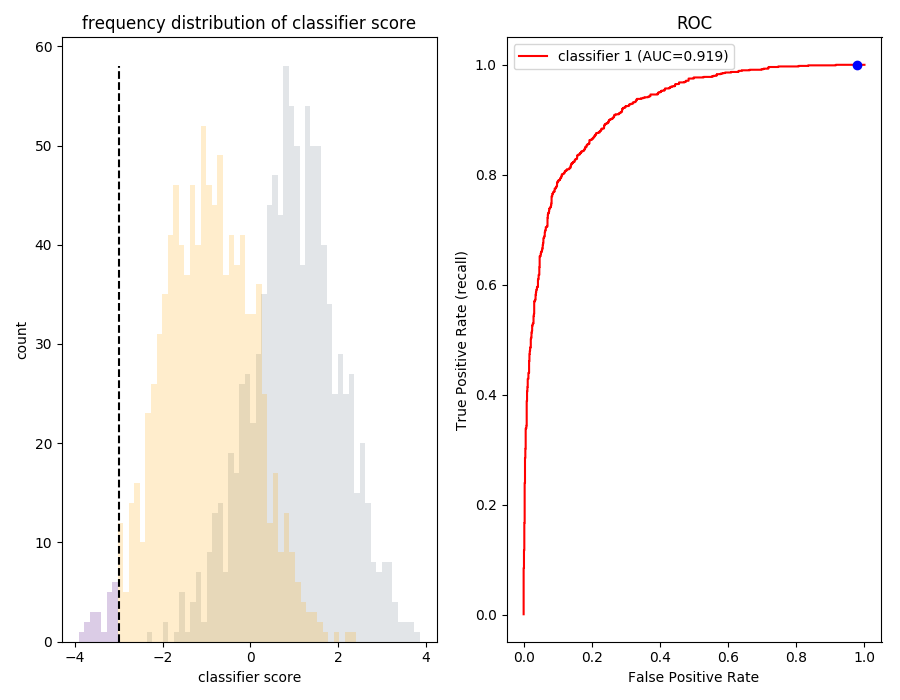

aW50ZXJhY3RpdmUoY2hpbGRyZW49KEZsb2F0U2xpZGVyKHZhbHVlPTAuMCwgZGVzY3JpcHRpb249dSd0aHJlc2hvbGQnLCBtYXg9NC4wLCBtaW49LTQuMCwgc3RlcD0wLjUpLCBPdXRwdXQoKSnigKY=


In [9]:
N = 1000
Xpos = generate_scores_gaus(N, 1, 1)
Xneg = generate_scores_gaus(N, -1, 1)

fig = plt.figure(figsize=(9, 7),  tight_layout=True)
#actual distribution (classifier 1)
ax_actdist = fig.add_subplot(1,2,1)
y = np.array([-1]*len(Xneg) + [1]*len(Xpos))
X = np.concatenate((Xneg, Xpos))

ax_roc = fig.add_subplot(1,2,2)
fpr, tpr, thresholds = metrics.roc_curve(y, X)
auc = metrics.auc(fpr, tpr)


def thresholdslider(cut):
    ax_actdist.clear()
    ax_roc.clear()
    actdistsig = ax_actdist.hist(Xpos, bins=50, alpha=0.2, label="signal")
    actdistbkg = ax_actdist.hist(Xneg, bins=50, alpha=0.2, label="bkg")
    ax_actdist.set_xlabel('classifier score')
    ax_actdist.set_ylabel('count')
    ax_actdist.title.set_text("frequency distribution of classifier score")
    #line_labels = ["signal", "bkg"]
    #fig.legend([ax_pdf, ax_actdist], labels=line_labels, loc="upper right", borderaxespad=0.5, title="class")
    thres = ax_actdist.vlines(x=cut, ymin=0, ymax=actdistsig[0].max(), linestyles='dashed')

    sigy, sigx, sigrectangle = actdistsig
    bkgy, bkgx, bkgrectangle = actdistbkg
    binindx_sig_th = binindx_bkg_th = 0
    TP=FN=TN=FP=0
    for i in range(len(sigx)-1):
        sigxmid = 0.5*(sigx[i] + sigx[i+1])
        sigxwidth = sigx[i+1] - sigx[i]
        if sigxmid < cut: #FN
            binindx_sig_th = i
            sigrectangle[i].set_facecolor('red')
            FN += sigy[i]*sigxwidth
        else: #TP
            sigrectangle[i].set_facecolor('slategrey')
            TP += sigy[i]*sigxwidth
            
        bkgxmid = 0.5*(bkgx[i] + bkgx[i+1])
        bkgxwidth = bkgx[i+1] - bkgx[i]
        if bkgxmid < cut: #TN 
            binindx_bkg_th = i
            bkgrectangle[i].set_facecolor('indigo')
            TN += bkgy[i]*bkgxwidth
        else: #FP
            bkgrectangle[i].set_facecolor('orange')
            FP += bkgy[i]*bkgxwidth
    
    TPR = (TP*1.0)/(TP+FN)
    FPR = (FP*1.0)/(FP+TN)
    roc = ax_roc.plot(fpr, tpr, '-r', label='classifier 1 (AUC=%.3f)'%auc)
    roc_pt = ax_roc.plot(FPR, TPR, 'ob')
    ax_roc.title.set_text("ROC")
    ax_roc.set_ylabel("True Positive Rate (recall)")
    ax_roc.set_xlabel("False Positive Rate")
    leg_roc = ax_roc.legend()
    



    fig.subplots_adjust(right=0.5)
    plt.tight_layout(pad=3.0)
    plt.show()
    fig.canvas.draw_idle()

interact(thresholdslider, cut=FloatSlider(description='threshold', min=-4.0, max=4.0, step=0.5, value=0) );

In the above definition of ROC curve, when there is no overlap between the probability distribution of the scores of the positive and negative class, the ROC curve should touch the (TPR=100%, FPR=0%) point and have an area under the curve (AUC) as 1.

As the overlap between the probability distribution of the scores of positive and negative class increases, the area under the curve become smaller than 1.

Therefore area under the curve (AUC) for ROC curve can be used as a metric to compare classiiers. In this case, greater the AUC better the classifier.

For other definitions of ROC like $FRP$ vs. $FNR$, smaller the AUC better the classifier.

The AUC in the above figure represents the average drift in the rank of the positive examples if you were to rank all the examples based on their scores (assuming the classifier gives hjigher score to the positive class). This is true as the AUC can be interpreted as the [nomalized Mann-Whitney U score](https://en.wikipedia.org/wiki/Mann%E2%80%93Whitney_U_test#Area-under-curve_(AUC)_statistic_for_ROC_curves) between the score distributions of the positive and negative class.

## Precision-recall (PR) curve

<div class="alert alert-block alert-danger">
(TODO: show positive and negative distributions with two different overlaps (two classifiers), keep the rel. normalizations the same, and with sliding threshold show the point on the PR curve, for now have scikitlearn fig as placeholder)
</div>

![title](https://scikit-learn.org/stable/_images/sphx_glr_plot_precision_recall_001.png)

As Precision is also a function of the threshold, the curve between Precision and Recall is used to compare different classifiers, similar to ROC curve. 
As we decrease the threshold (loosen our acceptance), we include more true positives so the true positive rate of the recall increases, while the increase in true positives w.r.t false positives would depend on the overlap of the score distribution of the positive and negative classes, ie the precision may increase or decrease depending on the overlap of the two class score distribution. Eventually, all the positive examples would be exhausted and further loosening the acceptance (decreasing the threshold) would just increase the number of false positivites, ie eventually the precision would decrease. Since the precision is sensitive to the overlap bewteen the two class score distributions, it can also compare different classifiers.

So, for a given threshold if the precision is higher, the overlap of the negative class in the selection is smaller. So the PR curve can be summarized as the precision averaged over threshold. As true positive count is a function of threshold, the average precision (AP) is the area under the PR curve. Higher the AP better is the classifier.

## When is PR curve better than ROC curve?

The PR curve looks at the precision which is a function of the actual yields (or counts) of the signal (positive class) and background (negative class). Therefore, the PR curve is better to understand the overlap between the actual distribution of the score of the signal and background by a classifier while the ROC curve can be only used to understand the overlap between the probability distributions of the scores of the positive and negative classes. The PR curve (and AP metric) is therefore useful in comparing classifiers when the classes in the dataset are imbalanced, such as in object detection where most of the area in an image is background, and in information retrival, where too most of the text is background. The ROC curve (and AUC metric) is useful in the case when the signal and background classes are balanced.

You can check it yourself by changing the relative normalization (or yield) of the background to signal class using the slider at the bottom of the plot below:

<IPython.core.display.Javascript object>


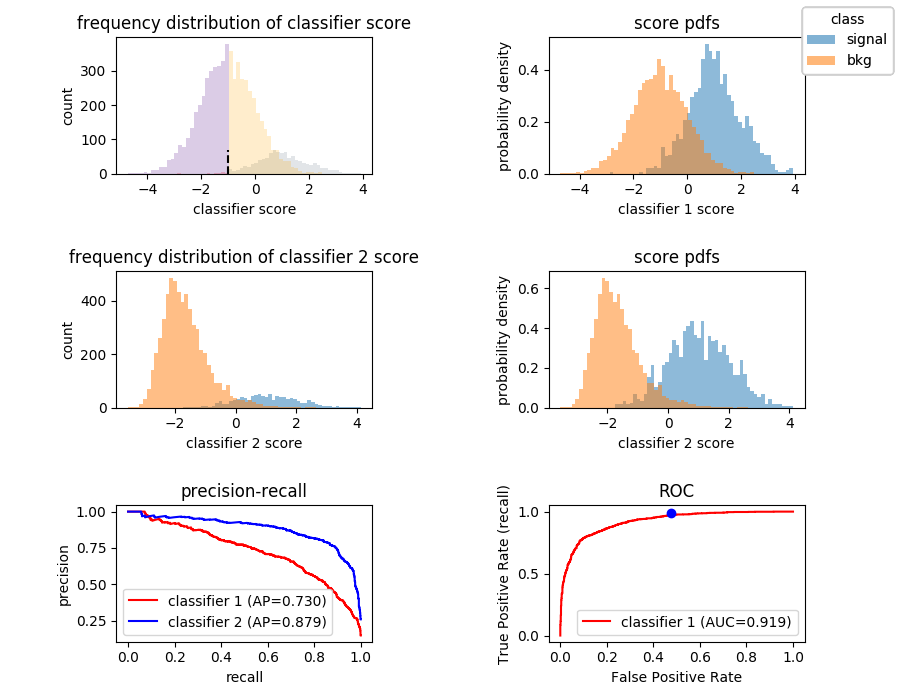

aW50ZXJhY3RpdmUoY2hpbGRyZW49KEZsb2F0U2xpZGVyKHZhbHVlPTEuMCwgZGVzY3JpcHRpb249dSdia2cvc2lnbmFsJywgbWF4PTEwLjEsIG1pbj0xLjAsIHN0ZXA9MC41KSwgT3V0cHV0KCnigKY=


In [10]:
fig = plt.figure(figsize=(9, 7),  tight_layout=True)

#actual distribution (classifier 1)
ax_actdist = fig.add_subplot(3,2,1)

#probability distribution (classiier 1)
ax_pdf = fig.add_subplot(3,2,2)

#actual distribution (classifier 2)
ax_actdistAlt = fig.add_subplot(3,2,3)

#probability distribution (classiier 2)
ax_pdfAlt = fig.add_subplot(3,2,4)

#precision-recall curve
ax_pr = fig.add_subplot(3,2,5)

#roc curve
ax_roc = fig.add_subplot(3,2,6)

N = 1000
Xpos = generate_scores_gaus(N, 1, 1)
XposAlt = generate_scores_gaus(N, 1, 1)
def update(bkg_to_sig_ratio):
    global Xneg
    Xneg = generate_scores_gaus(bkg_to_sig_ratio*N, -1, 1)
    XnegAlt = generate_scores_gumbel(bkg_to_sig_ratio*N, -2, 0.6)
    
    y = np.array([-1]*len(Xneg) + [1]*len(Xpos))
    X = np.concatenate((Xneg, Xpos))

    precision, recall, thresholds = metrics.precision_recall_curve(y, X)
    ap = metrics.auc(recall, precision)
    fpr, tpr, thresholds = metrics.roc_curve(y, X)
    auc = metrics.auc(fpr, tpr)

    yAlt = np.array([-1]*len(XnegAlt) + [1]*len(XposAlt))
    XAlt = np.concatenate((XnegAlt, XposAlt))

    precisionAlt, recallAlt, thresholdsAlt = metrics.precision_recall_curve(yAlt, XAlt)
    apAlt = metrics.auc(recallAlt, precisionAlt)
    fprAlt, tprAlt, thresholdsAlt = metrics.roc_curve(yAlt, XAlt)
    aucAlt = metrics.auc(fprAlt, tprAlt)
    
    
    ax_actdist.clear()
    ax_pdf.clear()
    ax_actdistAlt.clear()
    ax_pdfAlt.clear()
    ax_pr.clear()
    ax_roc.clear()
    
    actdist = ax_actdist.hist(Xpos, bins=50, alpha=0.5, label="signal")
    actdist = ax_actdist.hist(Xneg, bins=50, alpha=0.5, label="bkg")
    ax_actdist.set_xlabel('classifier 1 score')
    ax_actdist.set_ylabel('count')
    ax_actdist.title.set_text("frequency distribution of classifier 1 score")
    
    pdf = ax_pdf.hist(Xpos, bins=50, alpha=0.5, normed=True, label="signal")
    pdf = ax_pdf.hist(Xneg, bins=50, alpha=0.5, normed=True, label="bkg")
    ax_pdf.set_xlabel('classifier 1 score')
    ax_pdf.set_ylabel('probability density')
    ax_pdf.title.set_text("score pdfs")
    
    actdistAlt = ax_actdistAlt.hist(XposAlt, bins=50, alpha=0.5, label="signal")
    actdistAlt = ax_actdistAlt.hist(XnegAlt, bins=50, alpha=0.5, label="bkg")
    ax_actdistAlt.set_xlabel('classifier 2 score')
    ax_actdistAlt.set_ylabel('count')
    ax_actdistAlt.title.set_text("frequency distribution of classifier 2 score")
    
    pdfAlt = ax_pdfAlt.hist(XposAlt, bins=50, alpha=0.5, normed=True, label="signal")
    pdfAlt = ax_pdfAlt.hist(XnegAlt, bins=50, alpha=0.5, normed=True, label="bkg")
    ax_pdfAlt.set_xlabel('classifier 2 score')
    ax_pdfAlt.set_ylabel('probability density')
    ax_pdfAlt.title.set_text("score pdfs")
    
    line_labels = ["signal", "bkg"]
    fig.legend([ax_pdf, ax_actdist], labels=line_labels, loc="upper right", borderaxespad=0.5, title="class")
    
    pr = ax_pr.plot(recall, precision, '-r', label='classifier 1 (AP=%.3f)'%ap)
    prAlt = ax_pr.plot(recallAlt, precisionAlt, '-b', label='classifier 2 (AP=%.3f)'%apAlt)
    ax_pr.title.set_text("precision-recall")
    ax_pr.set_xlabel("recall")
    ax_pr.set_ylabel("precision")
    leg_pr = ax_pr.legend()
    
    roc = ax_roc.plot(fpr, tpr, '-r', label='classifier 1 (AUC=%.3f)'%auc)
    rocAlt = ax_roc.plot(fprAlt, tprAlt, '-b', label='classifier 2 (AUC=%.3f)'%aucAlt)
    ax_roc.title.set_text("ROC")
    ax_roc.set_ylabel("True Positive Rate (recall)")
    ax_roc.set_xlabel("False Positive Rate")
    leg_roc = ax_roc.legend()

    
    
    fig.subplots_adjust(right=0.5)
    plt.tight_layout(pad=3.0)
    plt.show()
    fig.canvas.draw_idle()
    


interact(update, bkg_to_sig_ratio=FloatSlider(description='bkg/signal', min=1.0, max=10.1, step=0.5, value=1.0) );

## References
<div class="alert alert-block alert-danger"> 
TODO
</div>